# 03 – Analysis and Visualization


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

This notebook presents a systematic analysis of all handshake experiments executed in the Key Exchange (KEX) performance evaluation framework.
It builds upon the parsed data from `02_parsing_and_exploration.ipynb`, consolidating runtime metrics, resource usage, and experiment metadata.
The data includes multiple experiments across three KEX modes (`classic`, `hybrid`, `pqc`) and two execution environments (`docker`, `native`), under various network profiles.


## 1. Introduction

### Objectives

The main objectives of this analysis are:

- Determine which key exchange variant performs best in terms of handshake duration and resource usage.
- Assess the impact of constrained network profiles on handshake performance taking into account the key exchange algorithm
- Compare the behavior of Docker-based versus native execution environments.
- Analyze the CPU and RAM usage across different modes and setups.
- Examine handshake stability under various simulated conditions.


### Research Questions

- How does a hybrid key exchange approach impact handshake efficiency under varying network conditions?
- What performance trade-offs exist between classical, hybrid, and post-quantum key exchange modes?
- Is Docker-based execution significantly different in terms of timing and system resource usage compared to native execution?
- How stable and robust are the different key exchange variants when deployed under constrained network profiles?

## 2. Methodology

This section outlines the experimental setup, including the execution environments, the applied network profiles, and the measurement approach.

Experiments were executed using both Docker-based containers and native Python processes. Simulated network conditions were applied using `tc netem` in the Docker setup to reflect realistic latency, packet loss, and bandwidth constraints.

### 2.1 Execution Environments

Two environments were used to run the experiments:

- **Docker**: Client and server were executed in isolated containers connected via a custom bridge network. Network manipulation using `tc netem` was applied directly inside the server container.
- **Native**: Client and server were executed as native Python processes on the host system without additional containerization or artificial network constraints.

Note: Only `experiment_01` was executed in both environments and can therefore be used for direct Docker vs. Native comparison.


### 2.2 Network Profiles

To simulate constrained or realistic environments, six network profiles were defined and applied to the Docker-based experiments via `tc netem`. These profiles emulate common real-world scenarios such as mobile networks, WiFi, and satellite communication.

Each profile defines parameters for:

- **Delay** (one-way latency per packet)
- **Packet loss** (random drop probability)
- **Rate limiting** (maximum bandwidth)
- **Burst and latency buffer** (for TBF shaping)

The profiles were applied to `experiment_02` through `experiment_06`. The native setup did not include artificial constraints.


| Experiment ID | Profile Name         | Delay | Packet Loss | Bandwidth | Burst  | Latency Buffer |
|---------------|----------------------|--------|-------------|-----------|--------|----------------|
| experiment_01 | None (baseline)      | —      | —           | —         | —      | —              |
| experiment_02 | netem_mobile         | 150ms  | 3%          | 700kbit   | 32kbit | 500ms          |
| experiment_03 | netem_lan            | 200ms  | 0%          | —         | —      | —              |
| experiment_04 | netem_package_loss   | 50ms   | 10%         | —         | —      | —              |
| experiment_05 | netem_good_wlan      | 30ms   | 0.5%        | 5mbit     | 64kbit | 200ms          |
| experiment_06 | netem_satelite       | 600ms   | 1%          | 1mbit     | 16kbit | 800ms          |

### 2.3 Hardware

All experiments were conducted locally on the following hardware:

- **Device**: MacBook Pro (Apple Silicon)
- **Chip**: Apple M4 Pro
- **Memory**: 24GB Unified Memory
- **CPU**: 12-core
- **GPU**: 16-core

Both Docker and native processes were executed on the same machine under low system load to ensure reproducibility and consistency.


## 3. Client vs. Server Duration Comparison

This section investigates the differences between the handshake duration measured by the client and the server.

Since both sides log their own timing independently, analyzing the gap between these values helps understand whether:

- network latency is accurately reflected in the measurements,
- one side systematically under- or overestimates the handshake duration,
- client-side and server-side processing times differ by key exchange mode.

### 3.1 Visualization

In [2]:
#Load dataframe from csv (created in previous notebook)
df_all = pd.read_csv("../data/all_measurements.csv")

In [27]:
# Filter only relevant columns for merging
client_df = df_all[df_all["side"] == "client"][["experiment", "setup", "mode", "duration_sec"]].copy()
client_df = client_df.rename(columns={"duration_sec": "duration_client"})

server_df = df_all[df_all["side"] == "server"][["experiment", "setup", "mode", "duration_sec"]].copy()
server_df = server_df.rename(columns={"duration_sec": "duration_server"})

In [28]:
# Merge client and server logs row-wise by experiment/setup/mode
df_merged = pd.merge(client_df, server_df, on=["experiment", "setup", "mode"])

# Calculate absolute and relative difference
df_merged["abs_diff"] = (df_merged["duration_client"] - df_merged["duration_server"]).abs()
df_merged["rel_diff"] = df_merged["abs_diff"] / df_merged[["duration_client", "duration_server"]].max(axis=1)

We calculate both the absolute and relative difference in handshake duration between client and server, grouped by mode and experiment.

This helps identify whether one side consistently reports higher durations and whether the gap depends on the network profile or execution mode.


In [29]:
df_diff_summary = (
    df_merged
    .groupby(["setup", "experiment", "mode"])[["duration_client", "duration_server", "abs_diff", "rel_diff"]]
    .median()
    .reset_index()
)

df_diff_summary

,setup,experiment,mode,duration_client,duration_server,abs_diff,rel_diff
0,docker,experiment_01,classic,0.000230,0.000113,0.000107,0.500000
1,docker,experiment_01,hybrid,0.000286,0.000244,0.000046,0.160808
2,docker,experiment_01,pqc,0.000205,0.000121,0.000091,0.423402
3,docker,experiment_02,classic,0.307870,0.154496,0.153761,0.499354
4,docker,experiment_02,hybrid,0.308751,0.155490,0.153503,0.497283
5,docker,experiment_02,pqc,0.308323,0.154585,0.153967,0.499370
6,docker,experiment_03,classic,0.408155,0.204739,0.203591,0.498703
7,docker,experiment_03,hybrid,0.410920,0.206668,0.204335,0.497467
8,docker,experiment_03,pqc,0.408299,0.204730,0.203722,0.498793
9,docker,experiment_04,classic,0.108011,0.054715,0.054384,0.503523


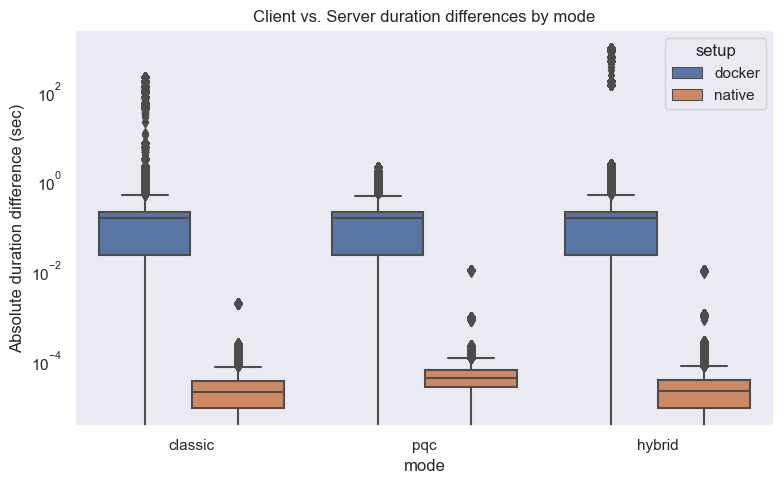

In [30]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_merged,
    x="mode",
    y="abs_diff",
    hue="setup"
)
plt.ylabel("Absolute duration difference (sec)")
plt.title("Client vs. Server duration differences by mode")
plt.grid(axis='y')
plt.yscale("log")
plt.tight_layout()
plt.show()

### 3.2 Oberservation & Interpretation

The plot above shows the absolute difference in handshake duration as measured independently by the client and the server, grouped by key exchange mode and execution environment. The Y-axis is logarithmic to reveal both small and large differences.

#### Key Observations:

- **Docker setup consistently shows higher client-server discrepancies** compared to the native environment.
- The **native setup reports differences in the sub-millisecond range**, typically between `10^-4` and `10^-3` seconds.
- In contrast, **Docker-based runs often reach 10–100 milliseconds**, with some extreme outliers in the 100+ second range (likely due to outliers, network queuing, or logging delays).
- Across all modes (`classic`, `pqc`, `hybrid`), the **discrepancy pattern is consistent**: Docker > Native.

#### Explanation:

This discrepancy is likely due to the fact that **network emulation (`netem`) was applied only on the server container**, introducing artificial delay, bandwidth throttling, and packet loss:

- Since the **client measures round-trip time**, any server-side delay is included in the client's `duration_sec`.
- The **server, however, logs only its local processing time** and is unaware of any additional delay imposed on its own outbound or inbound traffic.
- This asymmetry explains why **client durations are often significantly higher** in Docker-based experiments.

#### Conclusion:

While the measurements from client and server are both valuable, **client-side durations provide a more comprehensive picture** in this setup, especially when `netem` is active. For comparative analysis and visualization, we therefore focus on client-side metrics unless explicitly noted.


## 4. Docker vs. Native Comparison


This section compares the performance of key exchange (KEX) algorithms in two different execution environments: **Docker** and **native (host)**.

We analyze:
- Duration of the key exchange
- CPU utilization
- RAM usage

### 4.1 Methodology

- Only **client-side measurements** are used in this section. These provide a complete picture of the key exchange process, including any network emulation delays.
- For each experiment we aggregate the client logs using **mean and median** statistics.
- The metrics are visualized across both execution environments.

> **Note:** Server-side metrics are excluded to ensure consistency, as `netem` was only applied to the server containers, leading to artificially skewed server-side results.


In [7]:
# Filter for experiment_01 and client side only
df_exp1_client = df_all[
    (df_all["experiment"] == "experiment_01") &
    (df_all["side"] == "client")
    ].copy()

df_exp1_client.groupby(["setup", "mode", "side"]).size().unstack()


side            client
setup  mode           
docker classic    1000
       hybrid     1000
       pqc        1000
native classic    1000
       hybrid     1000
       pqc        1000

### 4.2 Handshake Duration

In the following cell, we calculate and compare the **mean** and **median handshake durations** across the three KEX modes (`classic`, `pqc`, `hybrid`) for both Docker and Native setups.

This allows us to evaluate performance consistency and identify any systematic delays introduced by containerization.


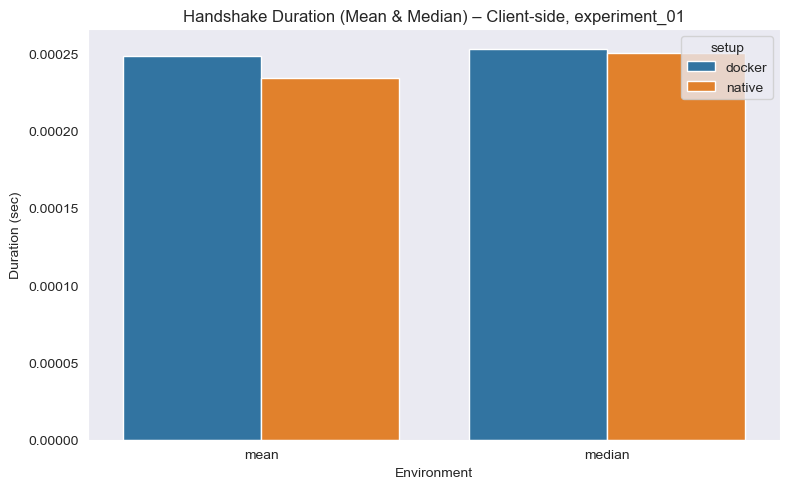

In [21]:
# Prepare data for seaborn (long format)
duration_stats = df_exp1_client.groupby(["setup"])["duration_sec"].agg(["mean", "median"]).reset_index()
duration_stats_long = duration_stats.melt(id_vars="setup", value_vars=["mean", "median"],
                                          var_name="metric", value_name="duration_sec")

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=duration_stats_long, x="metric", y="duration_sec", hue="setup")
plt.title("Handshake Duration (Mean & Median) – Client-side, experiment_01")
plt.ylabel("Duration (sec)")
plt.xlabel("Environment")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

The bar chart above shows the average (mean) and median handshake durations for both the Docker and Native setups, based solely on **client-side measurements** from experiment_01. Since this experiment was conducted **without network constraints (no `netem`)**, it offers a clean baseline comparison between the two environments.

#### Observations:

- **Durations across both environments are very close**, with only marginal differences in both mean and median values.
- The **Native setup is slightly faster on average**, as indicated by a lower mean duration compared to Docker.
- Interestingly, the **median for Native is slightly higher** than for Docker, indicating the presence of some outliers in the Docker runs that increased the average.

#### Interpretation:

- These small discrepancies suggest that, **in the absence of artificial network constraints**, Docker introduces minimal overhead for the handshake process.
- However, the difference in mean vs. median hints at **a slightly higher variability in Docker performance**, possibly due to container-level scheduling, I/O abstraction, or CPU allocation differences on macOS.
- Overall, **the environments behave comparably**, confirming that Docker can serve as a valid baseline for KEX performance evaluation, especially when controlling for outliers and focusing on medians.








### 4.3 CPU & RAM Comparison

The following bar plot shows the mean duration per key exchange mode, grouped by execution environment.


This section compares the system resource consumption of different Key Exchange (KEX) modes under Docker and native execution environments. Specifically, we analyze:

- **CPU usage** (`cpu_percent`)
- **RAM usage** (`ram_percent`)

Both metrics were recorded on the client side during each handshake and provide insights into the computational cost of each mode in both setups.

#### Methodology

- We use only **client-side logs from `experiment_01`**, where no artificial network constraints were applied.
- For each combination of environment (`docker`, `native`) we compute the **median** value of CPU and RAM usage.

In [29]:
# Group only by setup and compute median for CPU and RAM
resource_stats_summary = (
    df_exp1_client
    .groupby("setup")[["cpu_percent", "ram_percent"]]
    .mean()
    .reset_index()
    .melt(id_vars="setup", var_name="resource", value_name="percent")
)
resource_stats_summary

,setup,resource,percent
0,docker,cpu_percent,3.858067
1,native,cpu_percent,0.011400
2,docker,ram_percent,10.366667
3,native,ram_percent,73.366667


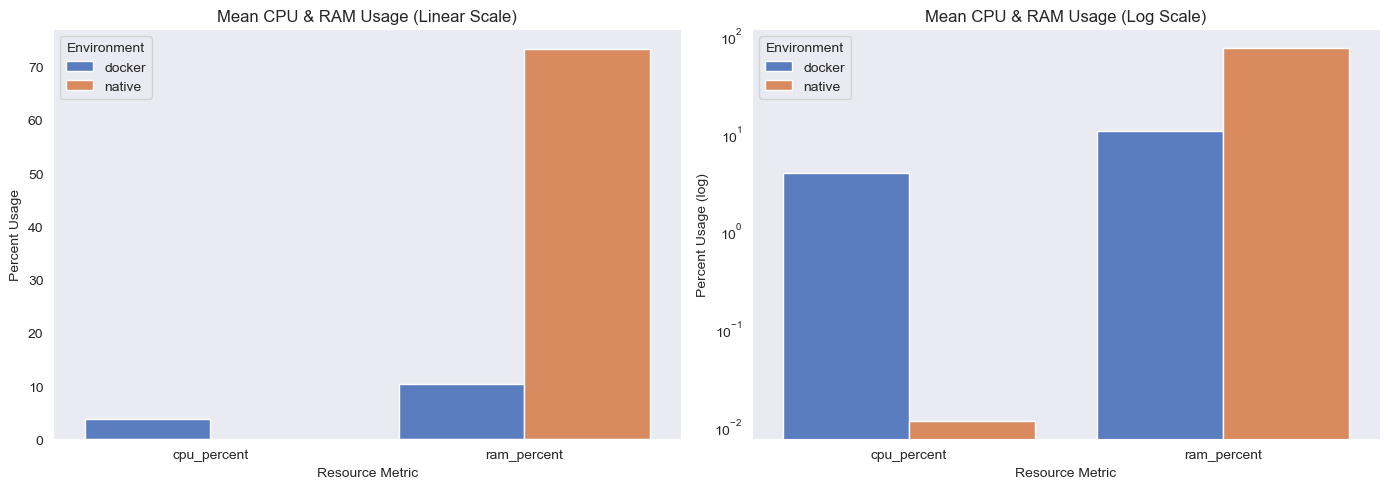

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# Plot 1: Linear scale
sns.barplot(data=resource_stats_summary, x="resource", y="percent", hue="setup", palette="muted", ax=axes[0])
axes[0].set_title("Mean CPU & RAM Usage (Linear Scale)")
axes[0].set_xlabel("Resource Metric")
axes[0].set_ylabel("Percent Usage")
axes[0].legend(title="Environment")
axes[0].grid(axis="y")

# Plot 2: Log scale
sns.barplot(data=resource_stats_summary, x="resource", y="percent", hue="setup", palette="muted", ax=axes[1])
axes[1].set_title("Mean CPU & RAM Usage (Log Scale)")
axes[1].set_xlabel("Resource Metric")
axes[1].set_ylabel("Percent Usage (log)")
axes[1].set_yscale("log")
axes[1].legend(title="Environment")
axes[1].grid(axis="y")

plt.tight_layout()
plt.show()

#### Observations

- **CPU usage** differs significantly between environments:
  - Docker: **3.86 %**
  - Native: **0.01 %**
  → Docker introduces substantial CPU overhead.

- **RAM usage** shows the opposite trend:
  - Docker: **10.37 %**
  - Native: **73.37 %**
  → Native consumes significantly more memory.

#### Interpretation

Although the Docker setup consumes **more CPU** and the native environment **more RAM**, the **measured handshake performance across modes is not affected in a meaningful way**:

- The **CPU load in Docker** is higher, but remains far below any threshold that would create a bottleneck or delay, especially since handshakes are brief and single-threaded.
- The **RAM consumption in the native setup**, while high in relative terms, does not appear to impact execution time — likely because the system still has sufficient headroom, and the extra usage may be tied to background processes or memory allocation patterns unrelated to the handshake itself.

Thus, the observed **performance differences between KEX modes (classic, hybrid, pqc)** are **comparable and valid across environments**.

> **Conclusion**: While absolute resource usage varies strongly between Docker and native setups, **this has no practical impact on the relative results of the experiments**. The comparisons between key exchange modes remain valid, regardless of execution environment.

#### Docker as the Preferred Environment

All experiments were executed in the **Docker environment** — intentionally and with good reason:

- **Reproducibility**: Docker provides a clean, isolated, and version-controlled environment, ensuring experiments can be reliably repeated on other machines or in the future.
- **Environment consistency**: No variation in software versions, system libraries, or dependencies, which could affect handshake behavior.
- **Scalability**: Multiple containers can be deployed in parallel for batch testing or simulations.
- **Portability**: The setup is easily shareable and runnable across Linux, macOS, and Windows.

Despite the **higher CPU usage**, Docker does **not compromise the validity or fairness** of the experimental results:

> **Conclusion**: The use of Docker introduces practical advantages without reducing the accuracy, comparability, or validity of the performance measurements. The results remain fully interpretable and meaningful across all KEX modes.


## 5. Comparison of Key Exchange Modes

This chapter compares the three key exchange variants — classical (ECDH), post-quantum (Kyber), and hybrid (ECDH + Kyber) — across several key dimensions: performance, resource consumption, and practical implementation complexity.

The goal is to provide a balanced view of the trade-offs between cryptographic security level and practical efficiency.

## 5.1 Methodology

This section describes the methodology used to compare the performance of three different key exchange (KEX) mechanisms: classical (ECDH), post-quantum (Kyber), and a hybrid approach combining both.

All measurements presented in this chapter are based on data collected from `experiment_01`. This experiment was executed without simulated network impairments, providing a clean and controlled environment to isolate the impact of the key exchange algorithm itself. The absence of latency, packet loss, or bandwidth restrictions ensures that the results reflect cryptographic and implementation-level differences rather than external network effects.

To ensure consistency and reproducibility, all experiments were conducted in the Docker-based setup. As shown in Chapter 4, Docker introduces a slightly higher CPU overhead compared to native execution. However, the decision to use Docker throughout this comparison is justified by the following considerations:

- **Environmental consistency**: All experiments run in an identical, containerized environment, eliminating interference from host-specific configurations or background processes.
- **Reproducibility**: The container setup ensures that the same results can be achieved across different machines and time points.
- **Automation and control**: Docker simplifies experimental automation, logging, and replication of test runs.
- **Portability**: The environment can be deployed across operating systems without modification.

Each KEX variant was evaluated using 1,000 handshake executions between a Docker-based client and server. The following metrics were recorded for each handshake:

- **Handshake duration** (in seconds)
- **CPU usage** (in percent)
- **RAM usage** (in percent)

The analysis in the subsequent sections compares the average and median values for each metric across the three KEX modes, with the objective of identifying practical performance trade-offs between classical, post-quantum, and hybrid key exchange strategies.

## 5.2 Handshake Duration per Mode

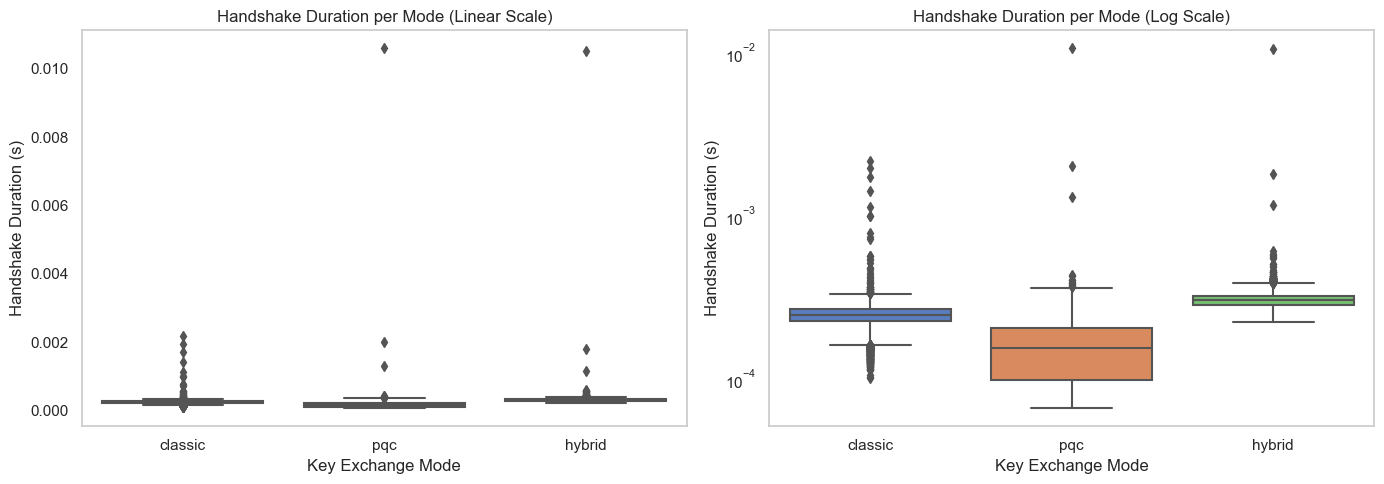

In [23]:
# Filter for client-side handshake data (if needed)
df_plot = df_exp1_client[df_exp1_client["side"] == "client"]

# Create two subplots: one with linear y-axis, one with logarithmic y-axis
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# Plot 1 – linear scale
sns.boxplot(data=df_plot, x="mode", y="duration_sec", palette="muted", ax=axes[0])
axes[0].set_title("Handshake Duration per Mode (Linear Scale)")
axes[0].set_xlabel("Key Exchange Mode")
axes[0].set_ylabel("Handshake Duration (s)")
axes[0].grid(axis='y')

# Plot 2 – logarithmic scale
sns.boxplot(data=df_plot, x="mode", y="duration_sec", palette="muted", ax=axes[1])
axes[1].set_title("Handshake Duration per Mode (Log Scale)")
axes[1].set_xlabel("Key Exchange Mode")
axes[1].set_ylabel("Handshake Duration (s)")
axes[1].set_yscale("log")
axes[1].grid(axis='y')

# Display the combined plot
plt.tight_layout()
plt.show()

The two boxplots above show the distribution of handshake durations for the three key exchange modes — classic (ECDH), pqc (Kyber), and hybrid — based on measurements from `experiment_01`.

The left-hand plot uses a linear y-axis, which emphasizes absolute differences in duration. The right-hand plot applies a logarithmic scale, revealing variations across several orders of magnitude, particularly in the tails of the distributions.

#### Observations

- All three modes show low median handshake durations in the sub-millisecond range.
- **Classic mode (ECDH)** has the tightest distribution, with few outliers.
- **PQC (Kyber)** shows a slightly broader spread with occasional low-duration outliers visible on the log scale.
- **Hybrid mode** exhibits a similarly concentrated distribution, with some notable outliers on both ends.
- In the linear-scale plot, the differences between the medians appear small; however, the log-scale view reveals a **greater spread** and highlights the presence of **occasional long-running handshakes**, particularly in the hybrid and pqc cases.

#### Interpretation

The results suggest that all three modes achieve very short and stable handshake durations under baseline conditions. However, the log-scaled plot shows that:

- **Kyber (pqc)** occasionally completes significantly faster than the median, likely due to favorable scheduling or minimal system interference during encapsulation.
- **Hybrid mode**, while generally stable, includes a small number of outliers with durations exceeding 10 ms. These may result from the cumulative cost of performing two key exchanges in parallel.

Overall, the performance differences are small in absolute terms but **relevant for time-critical applications** such as IoT, where even millisecond-level delays matter. Importantly, the **use of hybrid KEX does not introduce systemic latency**, but its increased cryptographic workload can occasionally cause longer handshakes in outlier cases.

### 5.3 CPU & RAM Comparison

This section analyzes the resource usage of the different key exchange modes during the handshake.

All values are based on client-side measurements from `experiment_01`, which was executed in both Docker and native environments without any active network emulation. Since the network was unconstrained, the results reflect the inherent computational cost of each key exchange mechanism.

The following visualizations compare CPU and RAM usage across the three KEX modes: **classic**, **pqc**, and **hybrid**.


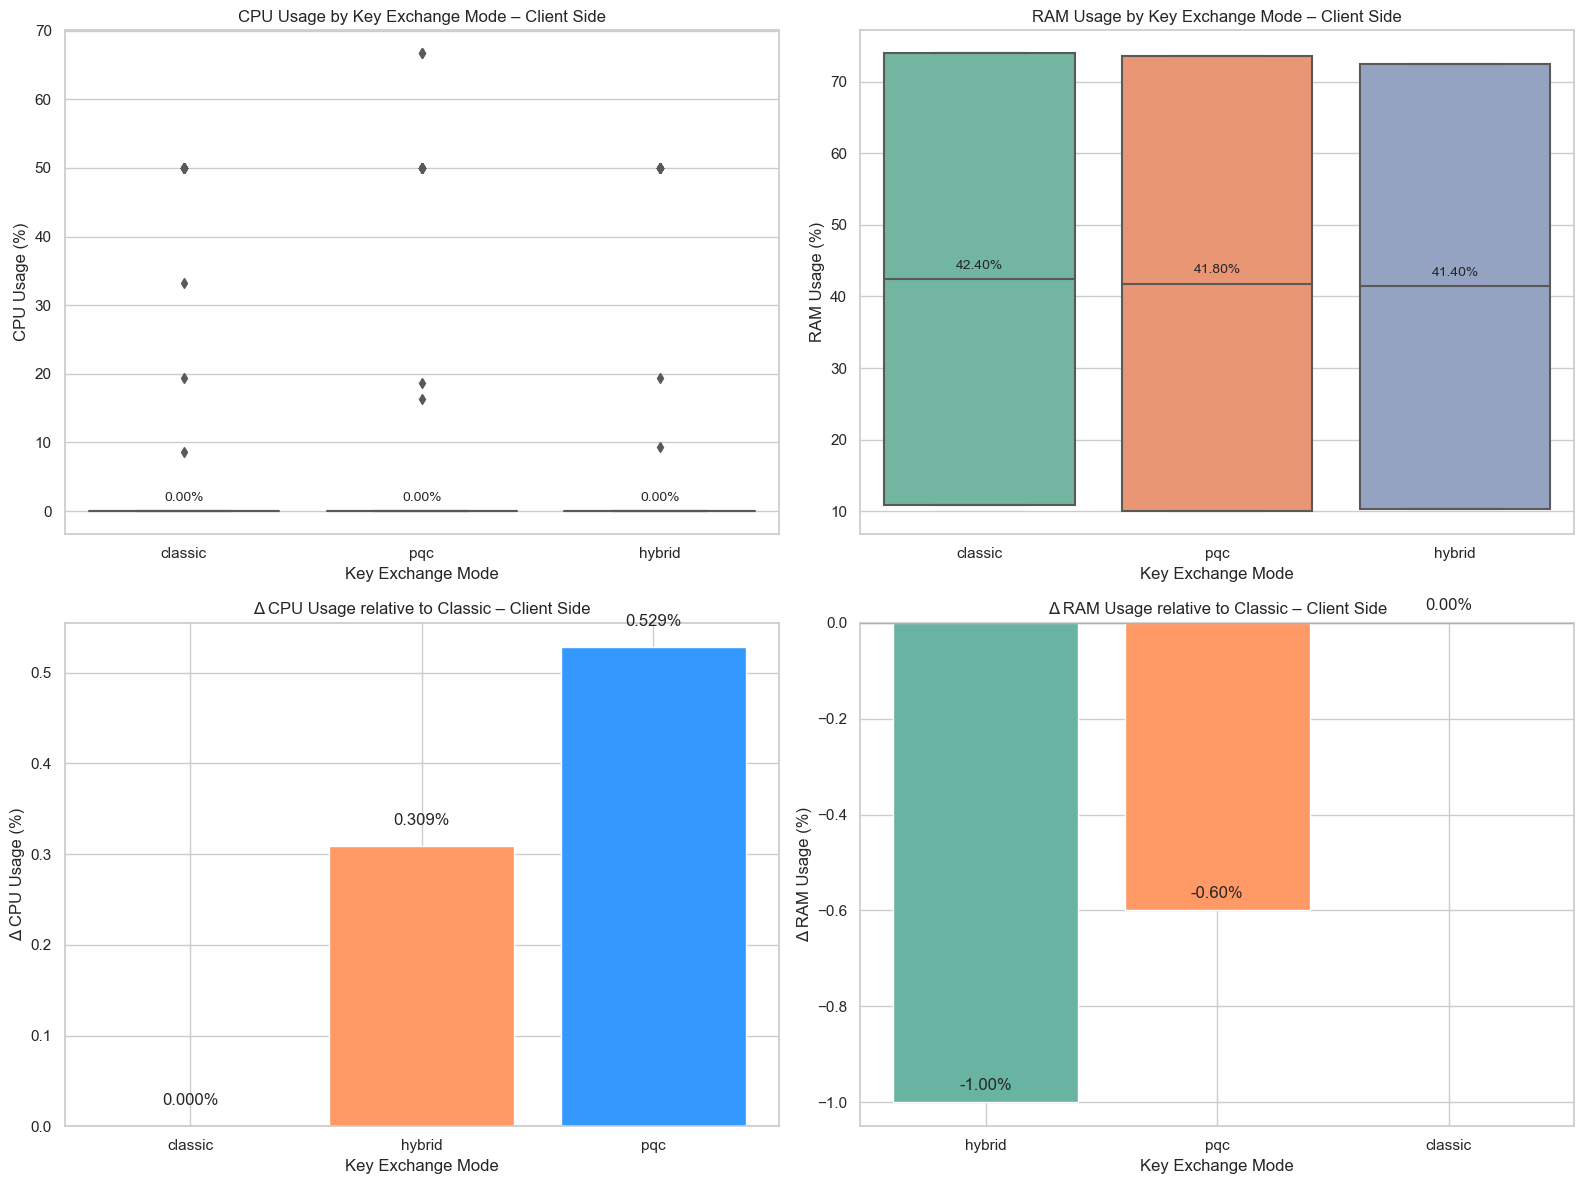

In [21]:
# Filter client-side only
df_plot = df_exp1_client[df_exp1_client["side"] == "client"]

# Calculate means and deltas
cpu_means = df_plot.groupby("mode")["cpu_percent"].mean().sort_values()
cpu_delta = cpu_means - cpu_means["classic"]

ram_means = df_plot.groupby("mode")["ram_percent"].mean().sort_values()
ram_delta = ram_means - ram_means["classic"]

# Prepare filtered data for top-left boxplot
cpu_data = df_plot[df_plot["cpu_percent"] < 80]

# Plot setup
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ---- Top left: CPU usage boxplot
sns.boxplot(ax=axes[0, 0], data=cpu_data, x="mode", y="cpu_percent", palette="Set2", showfliers=True)
axes[0, 0].set_title("CPU Usage by Key Exchange Mode – Client Side")
axes[0, 0].set_ylabel("CPU Usage (%)")
axes[0, 0].set_xlabel("Key Exchange Mode")
for i, mode in enumerate(cpu_data["mode"].unique()):
    median = cpu_data[cpu_data["mode"] == mode]["cpu_percent"].median()
    axes[0, 0].text(i, median + 1, f"{median:.2f}%", ha="center", va="bottom", fontsize=10)

# ---- Top right: RAM usage boxplot
sns.boxplot(ax=axes[0, 1], data=df_plot, x="mode", y="ram_percent", palette="Set2", showfliers=True)
axes[0, 1].set_title("RAM Usage by Key Exchange Mode – Client Side")
axes[0, 1].set_ylabel("RAM Usage (%)")
axes[0, 1].set_xlabel("Key Exchange Mode")
for i, mode in enumerate(df_plot["mode"].unique()):
    median = df_plot[df_plot["mode"] == mode]["ram_percent"].median()
    axes[0, 1].text(i, median + 1, f"{median:.2f}%", ha="center", va="bottom", fontsize=10)

# ---- Bottom left: Δ CPU usage bar chart
bars = axes[1, 0].bar(cpu_delta.index, cpu_delta.values, color=["#69b3a2", "#ff9966", "#3399ff"])
axes[1, 0].axhline(0, color='black', linewidth=0.8)
axes[1, 0].set_title("Δ CPU Usage relative to Classic – Client Side")
axes[1, 0].set_ylabel("Δ CPU Usage (%)")
axes[1, 0].set_xlabel("Key Exchange Mode")
for bar in bars:
    yval = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.3f}%", ha='center', va='bottom')

# ---- Bottom right: Δ RAM usage bar chart
bars = axes[1, 1].bar(ram_delta.index, ram_delta.values, color=["#69b3a2", "#ff9966", "#3399ff"])
axes[1, 1].axhline(0, color='black', linewidth=0.8)
axes[1, 1].set_title("Δ RAM Usage relative to Classic – Client Side")
axes[1, 1].set_ylabel("Δ RAM Usage (%)")
axes[1, 1].set_xlabel("Key Exchange Mode")
for bar in bars:
    yval = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### Observation

The CPU and RAM usage across the three key exchange modes (`classic`, `pqc`, `hybrid`) was measured on the client side during the handshake. The data was visualized using boxplots (absolute values) and bar charts (relative to the `classic` baseline).

- **CPU usage** remained consistently low across all modes, with median values close to 0%. Nonetheless, the mean values reveal small but measurable increases:
  - `pqc` shows the highest average CPU usage, approximately **+0.53%** compared to `classic`.
  - `hybrid` mode is slightly more efficient, with an increase of **+0.31%** over `classic`.
- **RAM usage**, in contrast, exhibited minor **decreases** in the post-quantum modes:
  - `hybrid` used about **1.00% less** RAM than `classic`.
  - `pqc` followed closely with a **0.60% decrease** relative to `classic`.


#### Interpretation

While the absolute CPU usage values are extremely low and may fall below the precision threshold of the measurement method, the consistent relative deltas suggest that post-quantum and hybrid modes do introduce a slightly higher CPU workload. This is likely due to the additional computational steps involved in Kyber encapsulation and decapsulation operations.

In terms of memory usage, both `pqc` and `hybrid` appear more memory-efficient than the classical ECDH-based exchange. One possible explanation is that Kyber’s internal structures are more lightweight in memory compared to elliptic curve computations in the used implementation.

Overall, the **performance impact of introducing post-quantum cryptography on resource usage is negligible** in practical terms. The observed differences lie well within operational tolerances for modern client systems and do not pose a bottleneck for deployment.

## 6. Performance Comparison across Network Profiles

This chapter analyzes how each key exchange mode (classic, hybrid, pqc) performs under varying network conditions — including latency, jitter, and packet loss. It combines both handshake duration and resource usage (CPU & RAM) metrics to evaluate robustness and efficiency in less-than-ideal networking environments.

### 6.1 Overview of Network Profiles

To assess the robustness and performance of different key exchange modes in realistic conditions, a range of network profiles was emulated using Linux’s `tc netem` utility. Each profile introduces specific constraints such as latency, bandwidth limits, and packet loss — simulating real-world conditions like mobile networks, satellite links, and unstable Wi-Fi.

The following table summarizes the network profiles used in experiments 02 through 06:

| Profile Name         | Delay  | Packet Loss | Bandwidth Limit | Burst Size | Latency |
|----------------------|--------|-------------|-----------------|------------|---------|
| **netem_mobile**     | 150 ms | 3%          | 700 kbit        | 32 kbit    | 500 ms  |
| **netem_lan**        | 200 ms | 0%          | —               | —          | —       |
| **netem_package_loss** | 50 ms  | 10%         | —               | —          | —       |
| **netem_good_wlan**  | 30 ms  | 0.5%        | 5 mbit          | 64 kbit    | 200 ms  |
| **netem_satelite**   | 600 ms | 1%          | 1 mbit          | 16 kbit    | 800 ms  |

These profiles were chosen to reflect a wide spectrum of network conditions:

- **Mobile & satellite links**: Introduce higher latency and moderate to high packet loss.
- **Package loss stress test**: Focuses on extreme unreliability (10% packet loss).
- **LAN**: Simulates a local network with no loss but moderate delay.
- **Good Wi-Fi**: Tests behavior in a moderately constrained but stable wireless environment.

By applying these conditions uniformly across all modes, we can systematically evaluate the sensitivity and adaptability of each key exchange mechanism.


### 6.2 Handshake Duration by Mode and Network Profile
#### Objective
This section examines how the handshake duration varies for each key exchange mode (`classic`, `pqc`, `hybrid`) across different network profiles. The goal is to evaluate which modes are most affected by delay, jitter, and packet loss, and which remain relatively stable.

In [33]:
df_all.head(10)

,Unnamed: 0,run,mode,duration_sec,shared_secret_length,cpu_percent,ram_percent,success,error,experiment,setup,side,netem
0,0,1,classic,0.156922,32,6.4,10.1,1,NaN,experiment_04,docker,client,NaN
1,1,2,classic,0.108111,32,0.8,10.1,1,NaN,experiment_04,docker,client,NaN
2,2,3,classic,0.104750,32,0.0,10.1,1,NaN,experiment_04,docker,client,NaN
3,3,4,classic,0.102940,32,0.8,10.1,1,NaN,experiment_04,docker,client,NaN
4,4,5,classic,0.104275,32,0.0,10.1,1,NaN,experiment_04,docker,client,NaN
5,5,6,classic,0.106385,32,0.8,10.1,1,NaN,experiment_04,docker,client,NaN
6,6,7,classic,0.363367,32,0.2,10.1,1,NaN,experiment_04,docker,client,NaN
7,7,8,classic,0.108098,32,0.0,10.1,1,NaN,experiment_04,docker,client,NaN
8,8,9,classic,0.103964,32,0.8,10.1,1,NaN,experiment_04,docker,client,NaN
9,9,10,classic,0.105510,32,0.0,10.1,1,NaN,experiment_04,docker,client,NaN


In [3]:
df_client = df_all[df_all["side"] == "client"]
duration_summary = df_client.groupby(["netem", "mode"])["duration_sec"].median().reset_index()
duration_summary.head(15)

,netem,mode,duration_sec
0,netem_good_wlan,classic,0.046921
1,netem_good_wlan,hybrid,0.047661
2,netem_good_wlan,pqc,0.047423
3,netem_lan,classic,0.408155
4,netem_lan,hybrid,0.410920
5,netem_lan,pqc,0.408299
6,netem_mobile,classic,0.307870
7,netem_mobile,hybrid,0.308751
8,netem_mobile,pqc,0.308323
9,netem_package_loss,classic,0.108011


#### 6.2.1 Overview: Median Handshake Duration

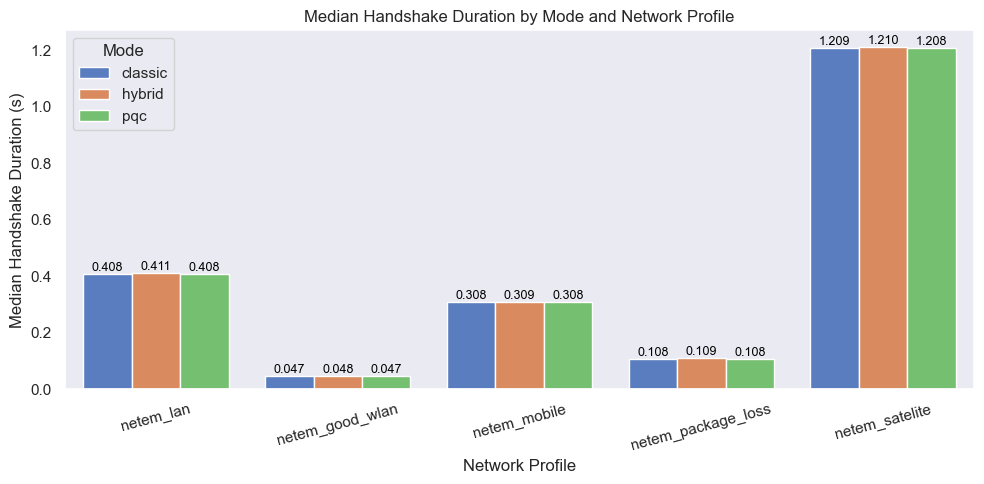

In [75]:
# Prepare: median handshake duration per (netem, mode)
duration_by_profile = df_client.groupby(["netem", "mode"])["duration_sec"].median().reset_index()

# Order for visual consistency
profile_order = ["netem_lan", "netem_good_wlan", "netem_mobile", "netem_package_loss", "netem_satelite"]
duration_by_profile["netem"] = pd.Categorical(duration_by_profile["netem"], categories=profile_order, ordered=True)

plt.figure(figsize=(10, 5))
sns.barplot(data=duration_by_profile, x="netem", y="duration_sec", hue="mode", palette="muted", order=profile_order)
plt.title("Median Handshake Duration by Mode and Network Profile")
plt.ylabel("Median Handshake Duration (s)")
plt.xlabel("Network Profile")
plt.xticks(rotation=15)
plt.grid(axis="y")
plt.legend(title="Mode")

# Optional: annotate values
for i, bar in enumerate(plt.gca().patches):
    height = bar.get_height()
    if height > 0:
        plt.gca().annotate(f"{height:.3f}", (bar.get_x() + bar.get_width() / 2, height),
                           ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()

The chart above shows the **median handshake duration** for each key exchange mode (`classic`, `pqc`, `hybrid`) across all network profiles. It enables a direct comparison between cryptographic configurations under controlled network variability.

##### Observation:
Across all profiles, the **differences in median duration between modes are marginal**. In most cases, the values are identical up to the third decimal place. Even under high-latency or lossy conditions, the additional overhead introduced by post-quantum (`pqc`) or hybrid key exchange is **negligible**.

##### Interpretation:
This suggests that the **choice of cryptographic mode has no measurable impact on median handshake performance**, even in degraded network environments. From a system design perspective, this makes `pqc` and `hybrid` suitable drop-in replacements for `classic` in latency-sensitive applications.


#### 6.2.2 Δ Duration relative to Classic

In [68]:
# Median durations grouped by netem + mode
medians = df_client.groupby(["netem", "mode"])["duration_sec"].median().unstack()

# Compute deltas to classic (row-wise)
delta_df = medians.sub(medians["classic"], axis=0)[["pqc", "hybrid"]].reset_index()

# Reorder profiles if needed
delta_df["netem"] = pd.Categorical(delta_df["netem"], categories=profile_order, ordered=True)
delta_df = delta_df.sort_values("netem")


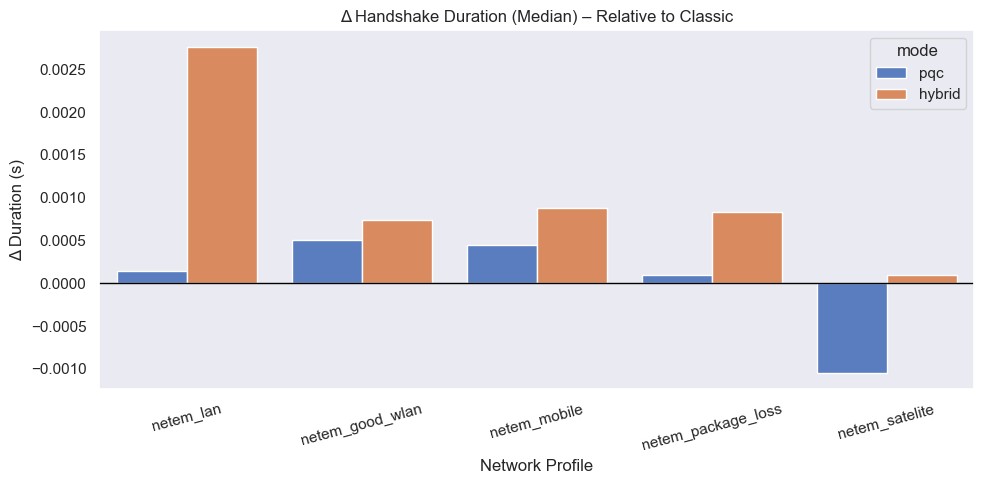

In [69]:
plt.figure(figsize=(10, 5))
delta_long = delta_df.melt(id_vars="netem", value_vars=["pqc", "hybrid"], var_name="mode", value_name="delta")
sns.barplot(data=delta_long, x="netem", y="delta", hue="mode", palette="muted")
plt.axhline(0, color="black", linewidth=1)
plt.title("Δ Handshake Duration (Median) – Relative to Classic")
plt.ylabel("Δ Duration (s)")
plt.xlabel("Network Profile")
plt.xticks(rotation=15)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

To highlight even minor differences, the following chart shows the **delta in handshake duration** between `pqc`/`hybrid` and the baseline `classic` mode. Positive bars indicate increased duration compared to `classic`.

##### Observation:
- All differences remain below **3 milliseconds**, even in worst-case scenarios.
- In certain profiles like `satelite`, `pqc` shows a **slightly faster** median duration than `classic`.
- The hybrid mode occasionally introduces small additional delay, but this is **not consistent** across profiles.

##### Interpretation:
These findings reinforce that **post-quantum cryptographic operations do not significantly delay the handshake process**, even under adverse network conditions. The slight advantages of `pqc` in satellite networks may reflect smaller payloads or more efficient processing under stress, though the effect is minor.

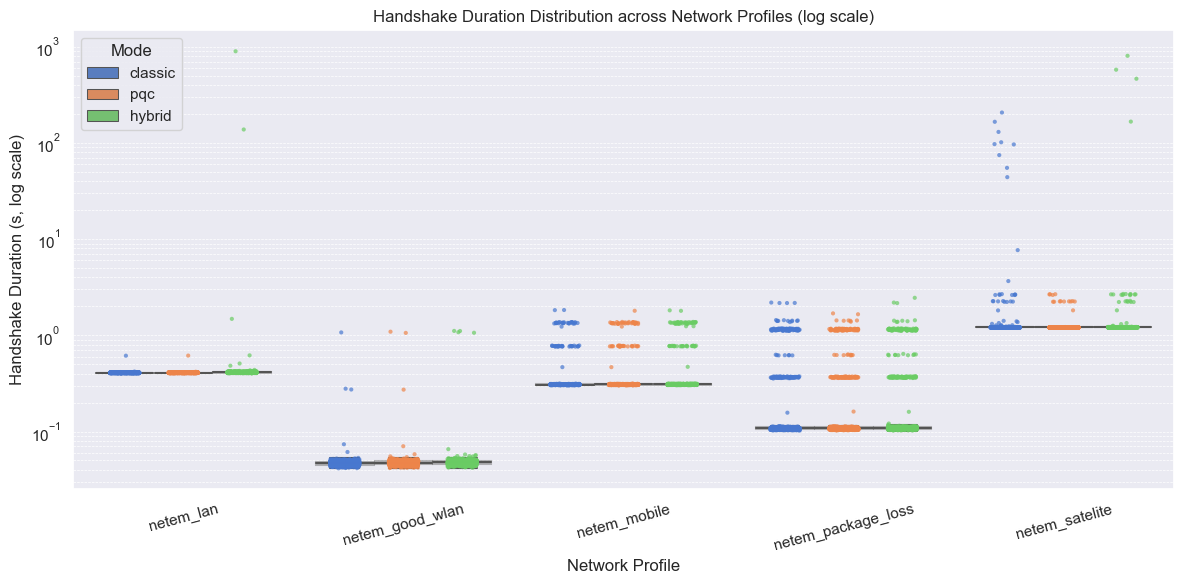

In [81]:
plt.figure(figsize=(12, 6))

# Boxplot als Grundstruktur
sns.boxplot(
    data=df_client,
    x="netem",
    y="duration_sec",
    hue="mode",
    order=profile_order,
    hue_order=["classic", "pqc", "hybrid"],
    palette="muted",
    showcaps=True,
    boxprops={"facecolor": "lightgray", "alpha": 0.4},
    showfliers=False,
    whiskerprops={"linewidth": 1}
)

# Stripplot drüberlegen für echte Datenpunkte
sns.stripplot(
    data=df_client,
    x="netem",
    y="duration_sec",
    hue="mode",
    dodge=True,
    order=profile_order,
    hue_order=["classic", "pqc", "hybrid"],
    palette="muted",
    jitter=0.2,
    size=3,
    alpha=0.7
)

plt.yscale("log")
plt.title("Handshake Duration Distribution across Network Profiles (log scale)")
plt.ylabel("Handshake Duration (s, log scale)")
plt.xlabel("Network Profile")
plt.xticks(rotation=15)
plt.grid(axis="y", which="both", linestyle="--", linewidth=0.5)

# Zwei Legenden vermeiden: Nur eine behalten
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:3], labels[:3], title="Mode", loc="upper left")

plt.tight_layout()
plt.show()


This plot illustrates the **full distribution** of handshake durations for each mode, using a combined box- and stripplot with a logarithmic y-axis. It visualizes timing variability across different network environments.

##### Observation:
- In **stable networks** (e.g. `good_wlan`, `lan`), all modes exhibit tightly clustered durations, with minimal spread.
- In **loss-prone or high-latency profiles** (`package_loss`, `satelite`), variance increases, but the **relative distribution between modes remains similar**.
- Outliers are present for all modes, but **no mode consistently shows higher instability**.

##### Interpretation:
Even under stress, **`pqc` and `hybrid` maintain similar timing stability** as `classic`. There is no evidence that post-quantum operations introduce erratic or unpredictable handshake durations. This strengthens their viability in latency- and reliability-sensitive environments.


### 6.3 Resource Usage by Mode and Network Profile

#### 6.3.0 Why Resource Usage COULD Matter under Varying Network Conditions

While CPU and RAM usage are primarily influenced by cryptographic operations rather than network latency or packet loss, analyzing these metrics across different network profiles is still essential for several reasons:

1. **Indirect Effects of Network Stress**
   Network profiles that simulate delay, bandwidth constraints, or packet loss can lead to retransmissions, longer connection lifetimes, or increased scheduling overhead. These side effects can translate into higher CPU activity and prolonged memory allocation during the handshake process.

2. **Compound Load Scenarios**
   Under stressed conditions, key exchange modes that are already computationally heavier—such as `hybrid` or `pqc`—may experience amplified resource demands. This analysis helps evaluate the robustness of each mode not only in isolation, but in more realistic, high-load environments.

3. **Practical Relevance for Constrained Devices**
   Embedded systems, IoT nodes, and mobile clients often operate under unreliable network conditions with limited processing power. Understanding how resource usage changes under these constraints is crucial for selecting a cryptographic mode that maintains performance without exhausting system capacity.

> **In essence, this section addresses an important question:**
> _Do post-quantum and hybrid key exchanges scale gracefully when network conditions worsen, or do they exhibit hidden performance costs under stress?_

The following sections explore CPU and RAM usage across modes and profiles to identify any such trade-offs or bottlenecks.


### 6.3.1 CPU Usage by Key Exchange Mode

In [6]:
cpu_medians = df_client.groupby(["netem", "mode"])["cpu_percent"].median().unstack()
profile_order = ["netem_lan", "netem_good_wlan", "netem_mobile", "netem_package_loss", "netem_satelite"]
cpu_medians = cpu_medians.loc[profile_order]

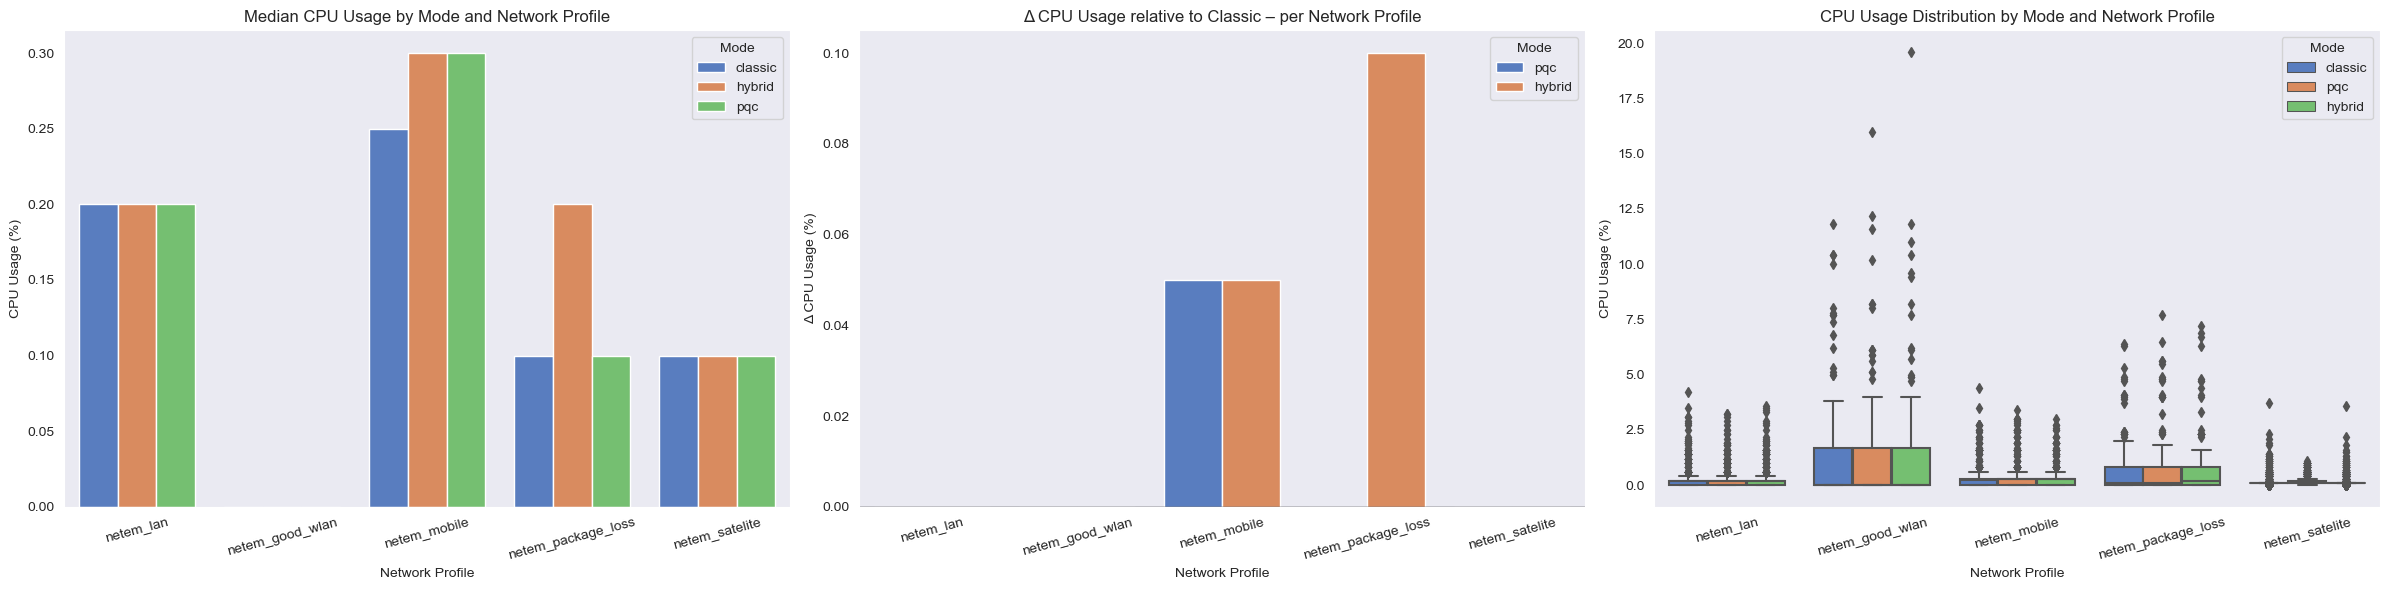

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Absolute CPU Usage – Medianwerte pro Profile & Mode
cpu_melted = cpu_medians.reset_index().melt(id_vars="netem", var_name="mode", value_name="cpu")

sns.barplot(
    data=cpu_melted,
    x="netem",
    y="cpu",
    hue="mode",
    palette="muted",
    ax=axes[0]
)
axes[0].set_title("Median CPU Usage by Mode and Network Profile")
axes[0].set_ylabel("CPU Usage (%)")
axes[0].set_xlabel("Network Profile")
axes[0].tick_params(axis='x', rotation=15)
axes[0].grid(axis="y")
axes[0].legend(title="Mode")

# Δ CPU Usage relative to Classic
sns.barplot(data=cpu_delta, x="netem", y="delta_cpu", hue="mode", palette="muted", ax=axes[1])
axes[1].axhline(0, color="black", linewidth=1)
axes[1].set_title("Δ CPU Usage relative to Classic – per Network Profile")
axes[1].set_ylabel("Δ CPU Usage (%)")
axes[1].set_xlabel("Network Profile")
axes[1].tick_params(axis='x', rotation=15)
axes[1].grid(axis="y")
axes[1].legend(title="Mode")

# Verteilung der CPU-Werte
sns.boxplot(
    data=df_client,
    x="netem",
    y="cpu_percent",
    hue="mode",
    order=profile_order,
    palette="muted",
    ax=axes[2]
)
axes[2].set_title("CPU Usage Distribution by Mode and Network Profile")
axes[2].set_ylabel("CPU Usage (%)")
axes[2].set_xlabel("Network Profile")
axes[2].tick_params(axis='x', rotation=15)
axes[2].grid(axis="y")
axes[2].legend(title="Mode")

plt.tight_layout()
plt.show()

#### **Observation**
- **Median CPU usage** remains nearly identical across all three KEX modes (`classic`, `hybrid`, `pqc`) across different network profiles.
- The **Δ CPU usage relative to classic** reveals minimal differences, typically below **0.05%**, with the exception of the *netem_package_loss* profile, where **hybrid** shows a small but noticeable increase (~0.1%).
- The **distribution plot** confirms that CPU usage is generally low across all modes. Outliers and variability appear evenly distributed, with no single KEX mode introducing significantly higher CPU demand.

#### **Interpretation**
- These findings indicate that **the choice of key exchange algorithm has negligible impact on client-side CPU consumption** during the TLS handshake.
- Both **hybrid** and **pqc** modes show similar CPU usage patterns compared to the **classic** mode, even in more challenging network environments.
- The slight CPU increase for **hybrid** under conditions of high packet loss may be attributed to the dual computation overhead (classic + PQC).
- Overall, **none of the KEX modes appear to introduce prohibitive CPU requirements**, suggesting that even post-quantum and hybrid approaches can be considered viable for deployment in constrained environments (e.g., IoT, mobile devices).

### 6.3.2 RAM Usage by Key Exchange Mode

In [14]:
# Median RAM per netem × mode
ram_medians = df_client.groupby(["netem", "mode"])["ram_percent"].median().unstack()
ram_medians = ram_medians.loc[profile_order]

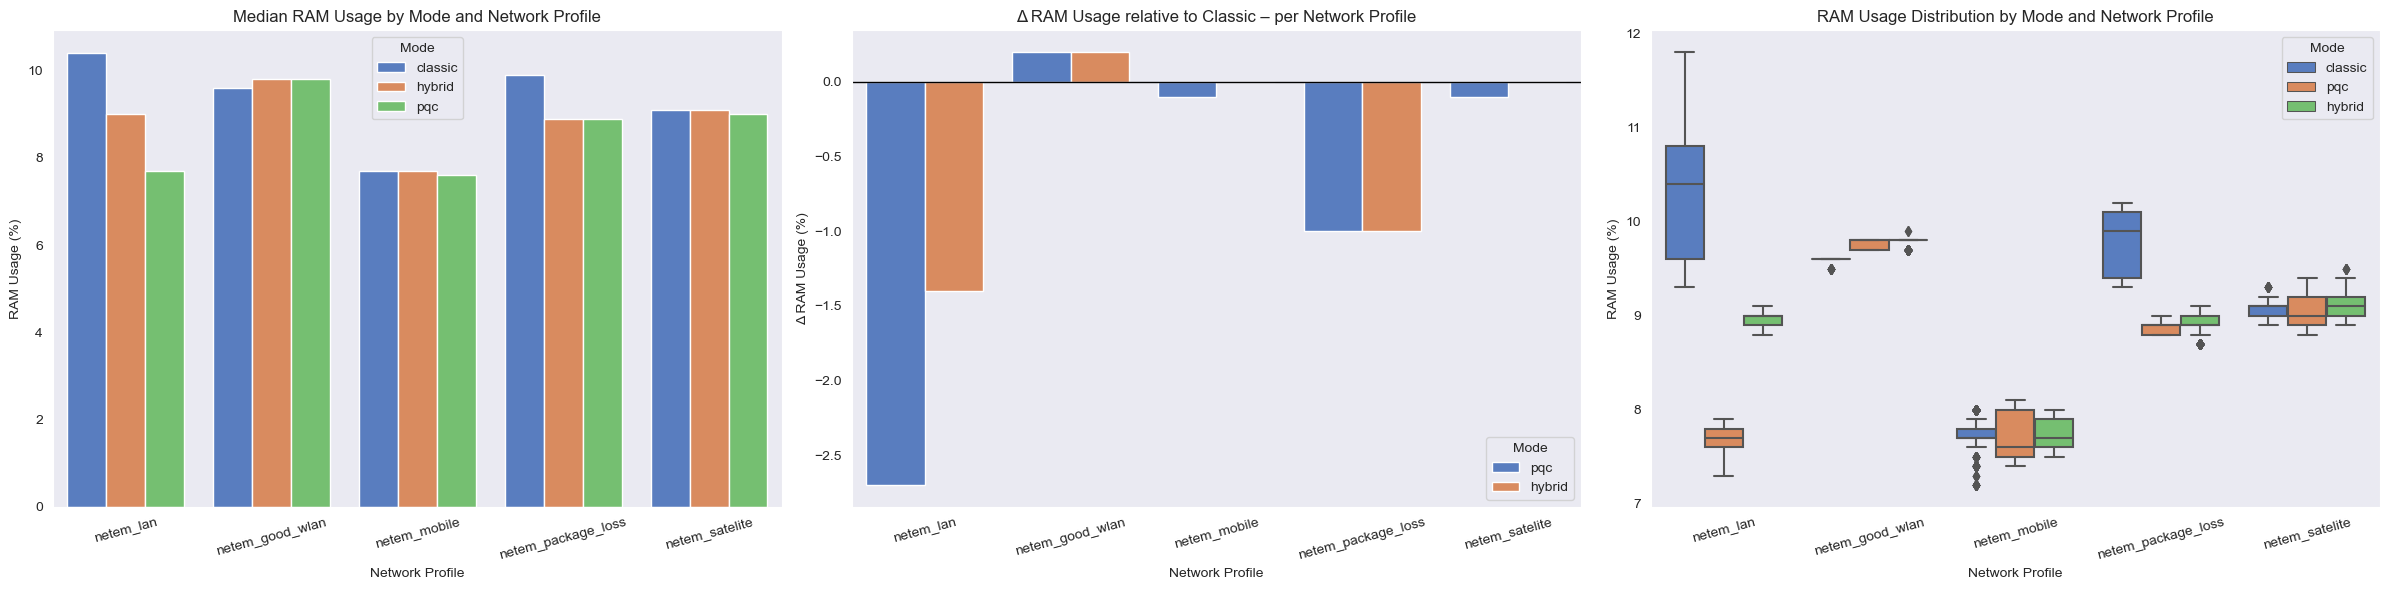

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Absolute RAM Usage – Medianwerte pro Profile & Mode
ram_melted = ram_medians.reset_index().melt(id_vars="netem", var_name="mode", value_name="ram")

sns.barplot(
    data=ram_melted,
    x="netem",
    y="ram",
    hue="mode",
    palette="muted",
    ax=axes[0]
)
axes[0].set_title("Median RAM Usage by Mode and Network Profile")
axes[0].set_ylabel("RAM Usage (%)")
axes[0].set_xlabel("Network Profile")
axes[0].tick_params(axis='x', rotation=15)
axes[0].grid(axis="y")
axes[0].legend(title="Mode")

# Δ RAM Usage relative to Classic
sns.barplot(data=ram_delta, x="netem", y="delta_ram", hue="mode", palette="muted", ax=axes[1])
axes[1].axhline(0, color="black", linewidth=1)
axes[1].set_title("Δ RAM Usage relative to Classic – per Network Profile")
axes[1].set_ylabel("Δ RAM Usage (%)")
axes[1].set_xlabel("Network Profile")
axes[1].tick_params(axis='x', rotation=15)
axes[1].grid(axis="y")
axes[1].legend(title="Mode")

# RAM Usage Distribution by Mode and Network Profile
sns.boxplot(
    data=df_client,
    x="netem",
    y="ram_percent",
    hue="mode",
    order=profile_order,
    palette="muted",
    ax=axes[2]
)
axes[2].set_title("RAM Usage Distribution by Mode and Network Profile")
axes[2].set_ylabel("RAM Usage (%)")
axes[2].set_xlabel("Network Profile")
axes[2].tick_params(axis='x', rotation=15)
axes[2].grid(axis="y")
axes[2].legend(title="Mode")

plt.tight_layout()
plt.show()


#### **Observation**
- **Median RAM usage** shows slight but consistent differences between key exchange modes.
- The **classic** mode generally consumes more RAM than both **hybrid** and **pqc**, especially under the *netem_lan* profile (over 2.5% difference).
- In profiles like *netem_good_wlan* and *netem_mobile*, the differences are marginal (< 0.5%), with **pqc** showing the lowest usage.
- The **Δ RAM usage relative to classic** confirms that both **pqc** and **hybrid** often require less RAM than the classic mode.
- The **distribution plot** reveals that while variability is present across all modes, **classic** tends to have a broader spread—indicating slightly less stability in memory usage under certain conditions.

#### **Interpretation**
- Contrary to intuitive expectations, **post-quantum and hybrid KEX modes do not increase RAM usage**. Instead, they appear to be more efficient in some scenarios.
- The reduced RAM footprint of **pqc** may be explained by smaller internal buffer requirements or faster processing during the TLS handshake, especially in noise-prone environments.
- The consistently lower or equal RAM usage of **hybrid** indicates that **the added complexity of combining classic and PQC mechanisms does not introduce a memory penalty**.
- These results are particularly relevant for **memory-constrained systems (e.g., embedded devices, mobile clients)**, where PQC or hybrid modes may actually offer an efficiency advantage over legacy approaches.


### 6.4 Mode Robustness Summary

This section evaluates how the different key exchange (KEX) modes perform in terms of **robustness** and **resource efficiency** under challenging network conditions. We focus on metrics such as handshake duration, CPU, and RAM usage across stress profiles: `netem_mobile`, `netem_package_loss`, and `netem_satelite`.

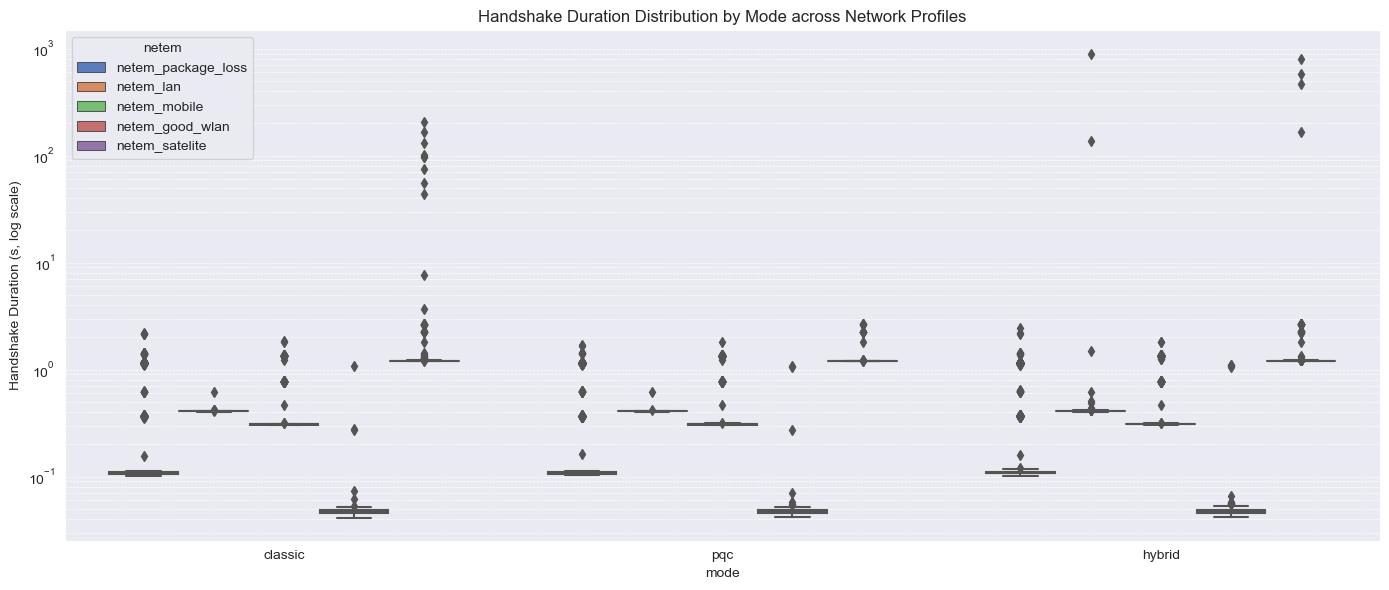

In [20]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_client, x="mode", y="duration_sec", palette="muted", hue="netem")
plt.yscale("log")
plt.title("Handshake Duration Distribution by Mode across Network Profiles")
plt.ylabel("Handshake Duration (s, log scale)")
plt.grid(axis='y', which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


#### Handshake Stability under Network Stress

The distribution plot of handshake durations across network profiles (log scale) shows that:
- All three modes — `classic`, `pqc`, and `hybrid` — exhibit similar distributions.
- No mode demonstrates significant instability or failure under network stress.

Observation: All KEX modes are robust in maintaining consistent handshake durations, even under high latency or packet loss conditions.


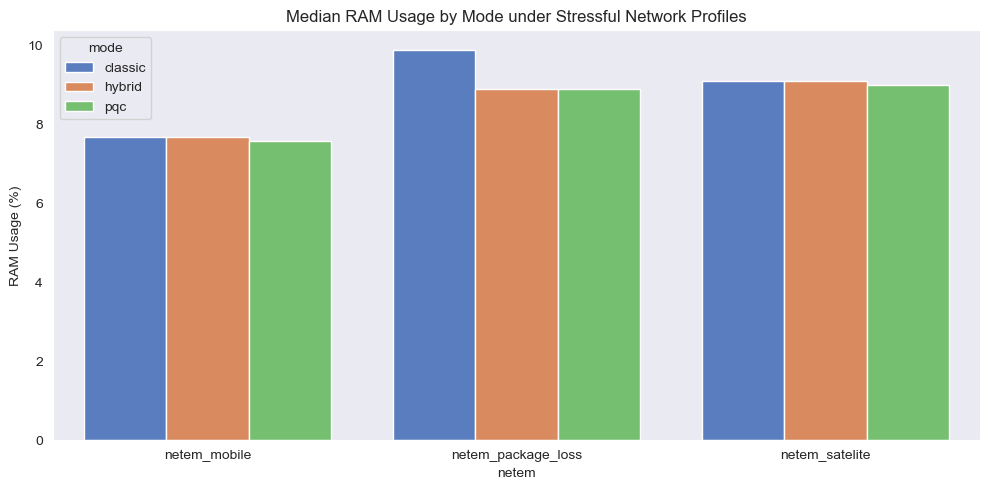

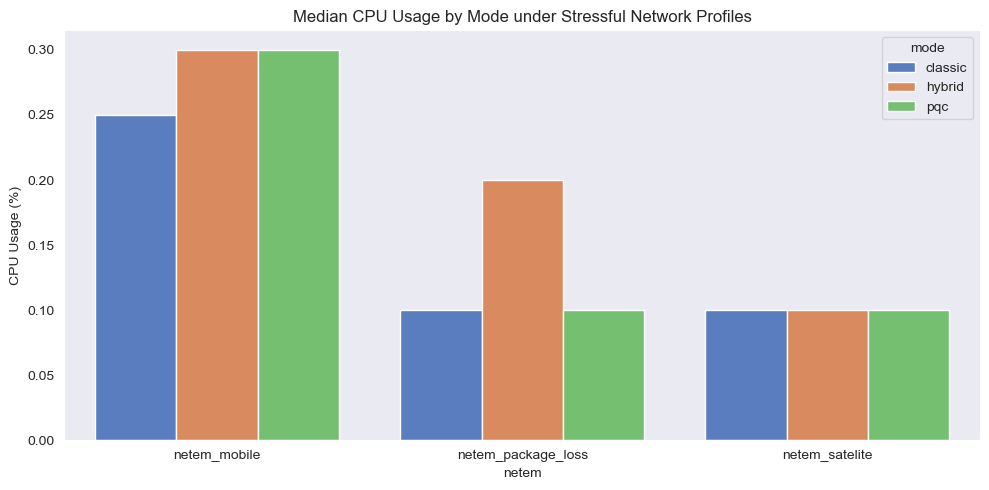

In [21]:
# Fokus auf stressige Netzwerkprofile
stress_profiles = ["netem_mobile", "netem_package_loss", "netem_satelite"]

# RAM
filtered_ram = ram_medians.loc[stress_profiles].reset_index().melt(id_vars="netem", var_name="mode", value_name="ram_usage")
plt.figure(figsize=(10, 5))
sns.barplot(data=filtered_ram, x="netem", y="ram_usage", hue="mode", palette="muted")
plt.title("Median RAM Usage by Mode under Stressful Network Profiles")
plt.ylabel("RAM Usage (%)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# CPU
filtered_cpu = cpu_medians.loc[stress_profiles].reset_index().melt(id_vars="netem", var_name="mode", value_name="cpu_usage")
plt.figure(figsize=(10, 5))
sns.barplot(data=filtered_cpu, x="netem", y="cpu_usage", hue="mode", palette="muted")
plt.title("Median CPU Usage by Mode under Stressful Network Profiles")
plt.ylabel("CPU Usage (%)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


#### RAM Efficiency under Stress

The RAM usage comparison reveals:
- `pqc` has the lowest RAM usage across almost all stressful network profiles.
- `classic` consumes the most RAM, particularly under `netem_package_loss`.

Observation: `pqc` is the most memory-efficient mode under adverse conditions.

#### CPU Efficiency under Stress

The CPU usage analysis indicates:
- `classic` is the most CPU-efficient, particularly in mobile and lossy networks.
- `hybrid` exhibits increased CPU load under `netem_package_loss`, standing out as the least efficient in that scenario.

Observation: `classic` provides the best CPU efficiency, while `hybrid` incurs moderate computational overhead under stress.

### 6.5 Interpretation and Practical Implications

The results presented across this chapter offer several important insights for selecting suitable key exchange (KEX) modes in real-world, network-constrained environments:

#### No Mode Breaks under Stress
All evaluated modes (`classic`, `pqc`, `hybrid`) demonstrated robust performance across varying and challenging network profiles. None showed a breakdown in handshake reliability, and variance in timing remained stable even under conditions of high latency and packet loss.

#### PQC and Hybrid Modes Are Viable Drop-in Replacements
Post-quantum (`pqc`) and hybrid key exchanges introduce no measurable performance penalties in terms of handshake duration. Even in the most constrained profiles (e.g., `netem_satelite`, `netem_package_loss`), the increase in handshake time is negligible (<3ms) and does not impact temporal predictability.

#### Resource Efficiency Supports Deployment on Constrained Devices
Surprisingly, `pqc` often outperforms the `classic` mode in terms of RAM usage and matches its CPU efficiency across most profiles. This suggests that post-quantum cryptography is not only secure, but also lightweight enough for deployment on devices with limited system resources (e.g., IoT, mobile clients).

#### Trade-offs and Recommendations
While the `classic` mode is slightly more CPU-efficient, it tends to consume more memory. The `hybrid` mode, although occasionally incurring a small CPU overhead, does not suffer from higher RAM usage. Therefore, selection should depend on context:
- For **low-latency, resource-constrained** environments: `pqc` is a strong candidate.
- For **backward compatibility** and **incremental deployment**: `hybrid` offers a secure bridge with minimal trade-offs.
- For **legacy systems or minimal CPU load**: `classic` remains the most efficient, but may be suboptimal in the long term.

#### Final Takeaway
Post-quantum and hybrid cryptographic modes are ready for deployment. They deliver strong security guarantees **without compromising performance or resource efficiency**, even in adverse network environments. This makes them a practical choice for future-proofing secure communications in heterogeneous and constrained deployment scenarios.
